In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns
from scipy import stats
from statsmodels.tsa import api as tsa
import statsmodels.api as sm
from sklearn import metrics
import rpy2.robjects.packages as rpack
from rpy2.robjects import r, pandas2ri, numpy2ri

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

presentation_fontsize=16
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [3]:
pandas2ri.activate()
numpy2ri.deactivate()

In [4]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est'].replace(0, np.nan).dropna()
    
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['jump_prop'] = discrete_vol['jumps'] / discrete_vol['quad']
log_vol = discrete_vol.transform(np.log).dropna()

In [5]:
log_vol.head()

absolute  diffusion    jumps    quad  jump_prop
0                                                          
2003-01-02   -4.8418    -9.7887  -9.4029 -8.8841    -0.5187
2003-01-03   -4.8204    -9.5487  -9.8776 -9.0065    -0.8711
2003-01-06   -5.0934   -10.3153 -10.1494 -9.5358    -0.6137
2003-01-07   -4.7491    -9.5571  -9.7226 -8.9433    -0.7793
2003-01-08   -4.9081   -10.1354  -9.6905 -9.1953    -0.4953

In [6]:
log_vol['diffusion'].dropna().autocorr()

0.8497433226261228

In [7]:
log_vol['jumps'].autocorr()

0.8326038103611363

In [8]:
log_vol['jump_prop'].autocorr()

0.26151801469906866

In [9]:
discrete_vol.corr()

absolute  diffusion   jumps    quad  jump_prop
absolute     1.0000     0.8236  0.8305  0.8811    -0.3245
diffusion    0.8236     1.0000  0.7421  0.9635    -0.2915
jumps        0.8305     0.7421  1.0000  0.8944    -0.1010
quad         0.8811     0.9635  0.8944  1.0000    -0.2348
jump_prop   -0.3245    -0.2915 -0.1010 -0.2348     1.0000

In [10]:
log_vol.corr()

absolute  diffusion   jumps    quad  jump_prop
absolute     1.0000     0.9778  0.9639  0.9963    -0.3334
diffusion    0.9778     1.0000  0.8983  0.9699    -0.5026
jumps        0.9639     0.8983  1.0000  0.9765    -0.0820
quad         0.9963     0.9699  0.9765  1.0000    -0.2947
jump_prop   -0.3334    -0.5026 -0.0820 -0.2947     1.0000

In [11]:
log_vol.diff().corr()

absolute  diffusion   jumps    quad  jump_prop
absolute     1.0000     0.8610  0.8052  0.9712    -0.1292
diffusion    0.8610     1.0000  0.4617  0.8137    -0.5578
jumps        0.8052     0.4617  1.0000  0.8809     0.4525
quad         0.9712     0.8137  0.8809  1.0000    -0.0234
jump_prop   -0.1292    -0.5578  0.4525 -0.0234     1.0000

In [12]:
diff_on_jumps = sm.OLS(endog=log_vol['diffusion'].dropna(), exog=log_vol['jumps'].dropna()).fit()

In [13]:
diff_on_jumps.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diffusion   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.797e+06
Date:                Sat, 10 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:13:49   Log-Likelihood:                -2681.2
No. Observations:                3713   AIC:                             5364.
Df Residuals:                    3712   BIC:                             5371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
jumps          1.0258      0.001   1340.626      0.000       1.024       1.027
==============================================================================
Omnibus:                       17.948   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.587
Skew:                          -0.014   Prob(JB):                     4.58e-06
Kurtosis:                       3.398   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
diff_on_jumps.scale

0.24823813110935652

In [15]:
sm.OLS(endog=log_vol['diffusion'].diff().dropna(), exog=log_vol['jumps'].diff().dropna()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diffusion   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     1006.
Date:                Sat, 10 Nov 2018   Prob (F-statistic):          1.73e-195
Time:                        15:13:50   Log-Likelihood:                -3056.2
No. Observations:                3712   AIC:                             6114.
Df Residuals:                    3711   BIC:                             6121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
jumps          0.5024      0.016     31.710      0.000       0.471       0.534
==============================================================================
Omnibus:                       12.175   Durbin-Watson:                   2.844
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.069
Skew:                           0.073   Prob(JB):                     0.000881
Kurtosis:                       3.263   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
diff_on_jumps.scale

0.24823813110935652

In [17]:
discrete_vol.corr()

absolute  diffusion   jumps    quad  jump_prop
absolute     1.0000     0.8236  0.8305  0.8811    -0.3245
diffusion    0.8236     1.0000  0.7421  0.9635    -0.2915
jumps        0.8305     0.7421  1.0000  0.8944    -0.1010
quad         0.8811     0.9635  0.8944  1.0000    -0.2348
jump_prop   -0.3245    -0.2915 -0.1010 -0.2348     1.0000

In [18]:
log_vol['diffusion'].dropna().size

3713

## AR Model for the Jumps

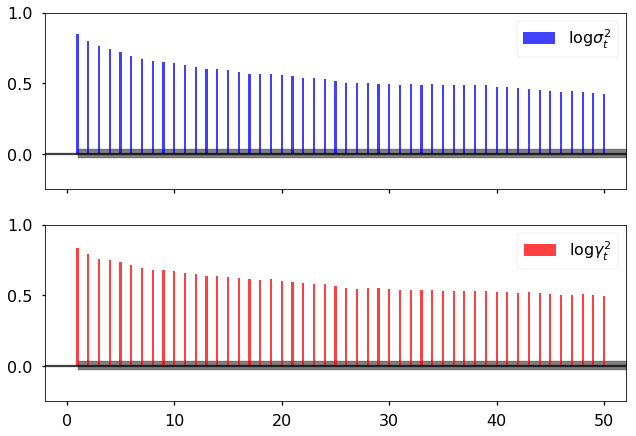

In [19]:
autocorr_fig, (diffusion_autocorr_ax, jumps_autocorr_ax) = mpl.pyplot.subplots(nrows=2, sharex=True, sharey=True)
jump_acf = tsa.acf(log_vol['jumps'].dropna(), nlags=50, unbiased=True)
jumps_autocorr_ax.bar(np.arange(1,jump_acf.size), jump_acf[1:], width=0.2, color='red', alpha=.75,
                      label='$\log \gamma^2_t$')
jumps_autocorr_ax.fill_between(x=np.arange(1, jump_acf.size+5), y1=1.96 * log_vol['jumps'].size**(-.5), color='black',
                              alpha=.5, y2=-1.96 * log_vol['jumps'].size**(-.5))
jumps_autocorr_ax.axhline(0, color='black', alpha=.75)
jumps_autocorr_ax.set_ylim([-0.25, 1])
jumps_autocorr_ax.set_xlim([-2, 52])
jumps_autocorr_ax.legend()
diffusion_acf = tsa.acf(log_vol['diffusion'].dropna(), nlags=50, unbiased=True)
diffusion_autocorr_ax.bar(np.arange(1,diffusion_acf.size), diffusion_acf[1:], width=0.2, color='blue', alpha=.75,
                      label='$\log \sigma^2_t$')
diffusion_autocorr_ax.fill_between(x=np.arange(1, diffusion_acf.size+5), y1=1.96 * log_vol['diffusion'].size**(-.5), 
                                   color='black', alpha=.5, y2=-1.96 * log_vol['jumps'].size**(-.5))
diffusion_autocorr_ax.axhline(0, color='black', alpha=.75)
diffusion_autocorr_ax.set_ylim([-0.25, 1])
diffusion_autocorr_ax.set_xlim([-2, 52])
diffusion_autocorr_ax.legend()
diffusion_autocorr_ax.yaxis.set_major_locator(ticker.FixedLocator([0, 0.5, 1]))
autocorr_fig.savefig('../doc/figures/autocorrelation_function.tmp.pdf', frameon=False, transparent=True, 
                     bbox_inches='tight')

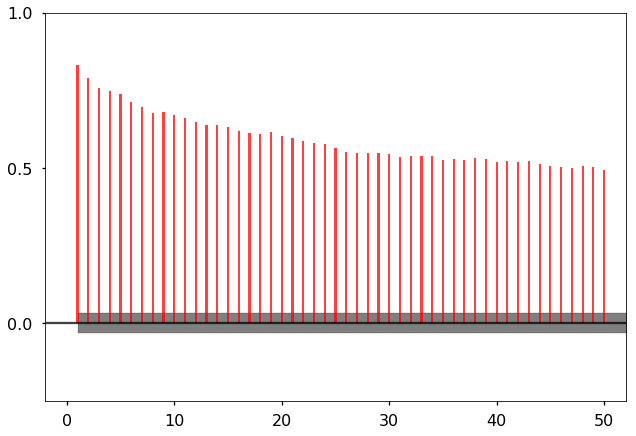

In [20]:
jump_autocorr_fig, jumps_autocorr_ax = mpl.pyplot.subplots()
jump_acf = tsa.acf(log_vol['jumps'], nlags=50, unbiased=True)
jumps_autocorr_ax.bar(np.arange(1,jump_acf.size), jump_acf[1:], width=0.2, color='red', alpha=.75,
                      label='$\log \gamma^2_t$')
jumps_autocorr_ax.fill_between(x=np.arange(1, jump_acf.size+5), y1=1.96 * log_vol['jumps'].size**(-.5),
                               color='black', alpha=.5, y2=-1.96 * log_vol['jumps'].size**(-.5))
jumps_autocorr_ax.axhline(0, color='black', alpha=.75)
jumps_autocorr_ax.set_ylim([-0.25, 1])
jumps_autocorr_ax.set_xlim([-2, 52])
jumps_autocorr_ax.yaxis.set_major_locator(ticker.FixedLocator([0, 0.5, 1]))
jump_autocorr_fig.savefig('../doc/figures/jump_autocorrelation_function.tmp.pdf', frameon=False, transparent=True, 
                     bbox_inches='tight')

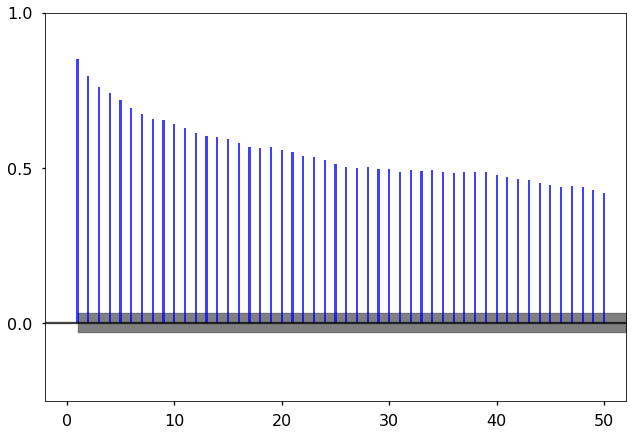

In [21]:
diffusion_autocorr_fig, diffusion_autocorr_ax = mpl.pyplot.subplots()
diffusion_acf = tsa.acf(log_vol['diffusion'], nlags=50, unbiased=True)
diffusion_autocorr_ax.bar(np.arange(1,diffusion_acf.size), diffusion_acf[1:], width=0.2, color='blue',
                          alpha=.75,
                      label='$\log \sigma^2_t$')
diffusion_autocorr_ax.fill_between(x=np.arange(1, diffusion_acf.size+5), 
                                   y1=1.96 * log_vol['diffusion'].size**(-.5), color='black', alpha=.5, 
                                   y2=-1.96 * log_vol['jumps'].size**(-.5))
diffusion_autocorr_ax.axhline(0, color='black', alpha=.75)
diffusion_autocorr_ax.set_ylim([-0.25, 1])
diffusion_autocorr_ax.set_xlim([-2, 52])
diffusion_autocorr_ax.yaxis.set_major_locator(ticker.FixedLocator([0, 0.5, 1]))
diffusion_autocorr_fig.savefig('../doc/figures/diffusion_autocorrelation_function.tmp.pdf', frameon=False, 
                               transparent=True, bbox_inches='tight')

In [22]:
fracdiff = rpack.importr('fracdiff')
# arfima = importr('arfima')

In [23]:
fracdiff_log_vol = pd.DataFrame(list(fracdiff.diffseries(log_vol['diffusion'].dropna(), .63)),
                                index=log_vol.dropna().index, columns=['diffusion'])
fracdiff_log_vol['jumps'] = pd.DataFrame(list(fracdiff.diffseries(log_vol['jumps'].dropna(), .63)),
                                index=log_vol.dropna().index)

In [24]:
fracdiff_diff_on_jumps = sm.OLS.from_formula('diffusion ~ jumps', data=fracdiff_log_vol).fit()
residuals = tsa.VAR(fracdiff_log_vol).fit(ic='bic', trend='nc').resid

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [25]:
a = fracdiff.fracdiff(discrete_vol['jumps'].apply(np.log).dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jumps is {0} and the standard erorr is {1}'.format(a['d'],a['stderror.dpq']))

The estimate for d in the jumps is [1] 0.4927327
 and the standard erorr is [1] 2.837248e-05



In [26]:
a = fracdiff.fdSperio(log_vol['jumps'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jumps is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

The estimate for d in the jumps is [1] 0.5988523
 and the standard erorr is [1] 0.03163982



In [27]:
a = fracdiff.fdGPH(log_vol['jumps'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jumps is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

The estimate for d in the jumps is [1] 0.6589118
 and the standard erorr is [1] 0.08310584



In [28]:
a = fracdiff.fracdiff(log_vol['diffusion'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the diffusion is {0} and the standard erorr is {1}'.format(
    a['d'],a['stderror.dpq']))

The estimate for d in the diffusion is [1] 0.4987934
 and the standard erorr is [1] 3.291599e-05



In [29]:
a = fracdiff.fdSperio(log_vol['diffusion'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the diffusion is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

The estimate for d in the diffusion is [1] 0.5702688
 and the standard erorr is [1] 0.034334



In [30]:
a = fracdiff.fdGPH(log_vol['diffusion'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jumps is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

The estimate for d in the jumps is [1] 0.616379
 and the standard erorr is [1] 0.08627568



In [31]:
a = fracdiff.fracdiff(log_vol['jump_prop'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jump proportion is {0} and the standard erorr is {1}'.format(
    a['d'],a['stderror.dpq']))

The estimate for d in the jump proportion is [1] 0.2129048
 and the standard erorr is [1] 6.254576e-06



In [32]:
a = fracdiff.fdGPH(log_vol['jump_prop'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jump proportion is {0} and the standard erorr is {1}'.format(
    a['d'],a['sd.reg']))

The estimate for d in the jump proportion is [1] 0.4711564
 and the standard erorr is [1] 0.08426772



In [33]:
0.4711564 + 1.96 * 0.08426772

0.6363211312

In [34]:
a = fracdiff.fdSperio(log_vol['jump_prop'].dropna())
a = dict(zip(a.names, list(a)))
print('The estimate for d in the jump proportion is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

The estimate for d in the jump proportion is [1] 0.4157496
 and the standard erorr is [1] 0.03598194



In [35]:
fracdiffed_diffusion = pd.DataFrame(list(fracdiff.diffseries(log_vol['diffusion'].dropna(), d=.61)))

In [36]:
fracdiffed_jumps = pd.DataFrame(list(fracdiff.diffseries(log_vol['jumps'].dropna(), d=.63)))

In [37]:
tsa.stattools.kpss(sm.OLS(endog=fracdiffed_diffusion, exog=fracdiffed_jumps).fit().resid)

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.12517336592457576,
 0.1,
 30,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [38]:
(discrete_vol['jumps'] / discrete_vol['quad']).autocorr()

0.23301225623479266

In [ ]:
jumps_on_vol_autocorr_fig, jumps_on_vol_autocorr_ax = mpl.pyplot.subplots()
jumps_on_vol_model = sm.OLS.from_formula('jumps ~ diffusion', data=log_vol).fit()
jumps_on_vol_acf = tsa.acf(jumps_on_vol_model.resid, nlags=50, unbiased=True)
jumps_on_vol_autocorr_ax.bar(np.arange(1,jumps_on_vol_acf.size), jumps_on_vol_acf[1:], width=0.2, color='purple', 
                             label=r'$\log \sigma^2_t - \hat{\beta}^{OLS} \log \gamma^2_t$')
jumps_on_vol_autocorr_ax.fill_between(x=np.arange(1, jump_acf.size+5), y1=1.96 * log_vol['jumps'].size**(-.5), color='black',
                              alpha=.5, y2=-1.96 * log_vol['jumps'].size**(-.5))
jumps_on_vol_autocorr_ax.axhline(0, color='black', alpha=.75)
jumps_on_vol_autocorr_ax.set_ylim([-0.25, 1])
jumps_on_vol_autocorr_ax.set_xlim([-2, 52])
jumps_on_vol_autocorr_ax.legend()
jumps_on_vol_autocorr_ax.yaxis.set_major_locator(ticker.FixedLocator([0, 0.5, 1]))
jumps_on_vol_autocorr_fig.savefig('../doc/figures/jump_on_vol_autocorrelation.tmp.pdf', frameon=False, 
                                  transparent=True, bbox_inches='tight')

In [ ]:
a = fracdiff.fdGPH(jumps_on_vol_model.resid)
a = dict(zip(a.names, list(a)))
print('The estimate for d in the residuals is {0} and the standard erorr is {1}'.format(a['d'],a['sd.reg']))

In [ ]:
a = fracdiff.fracdiff(jumps_on_vol_model.resid)
a = dict(zip(a.names, list(a)))
print('The estimate for d in the residuals is {0} and the standard erorr is {1}'.format(a['d'],a['stderror.dpq']))

In [ ]:
diffusion_on_jumps = sm.OLS.from_formula('diffusion ~ jumps', data=log_vol).fit()
diffusion_on_jumps.summary()

In [ ]:
jumps_on_vol_model.summary()

In [ ]:
ar_jump_model = sm.OLS.from_formula('jumps ~ jumps.shift(1)', data=log_vol).fit()
ar_jump_model.summary()

In [ ]:
jump_ar_fig, jump_ar_ax = mpl.pyplot.subplots()
jump_ar_ax.plot(log_vol['jumps'], label="True Values")
jump_ar_ax.plot(ar_jump_model.resid, label="Residuals")
jump_ar_ax.plot(ar_jump_model.fittedvalues, label="Fitted Values")

In [ ]:
jump_ar_autocorr_fig, jump_ar_autocorr_ax = mpl.pyplot.subplots()
sm.graphics.tsa.plot_acf(ar_jump_model.resid, lags=20, title="", ax=jump_ar_autocorr_ax)

## Testing for Short Memory

In [ ]:
tsa.stattools.kpss(log_vol['diffusion'].dropna())

In [ ]:
tsa.stattools.kpss(log_vol['jumps'].dropna())

In [ ]:
tsa.stattools.kpss(log_vol['jump_prop'].dropna())

In [ ]:
tsa.stattools.kpss((discrete_vol['jumps'].dropna() /  discrete_vol['quad']).dropna())

In [ ]:
tsa.stattools.adfuller(discrete_vol['jump_prop'].dropna())

In [ ]:
tsa.stattools.adfuller(log_vol['jump_prop'].dropna())

In [ ]:
tsa.stattools.adfuller(log_vol['diffusion'].dropna())

In [ ]:
tsa.stattools.adfuller(log_vol['jumps'])

In [ ]:
np.sqrt(148.7673)

In [ ]:
np.sqrt(78.0044)

In [ ]:
jumps_cause_diff = tsa.stattools.grangercausalitytests(log_vol[['diffusion', 'jumps']], maxlag=5)

In [ ]:
np.sqrt(298.0917)

In [ ]:
granger_results2 = tsa.stattools.grangercausalitytests(log_vol[['jumps', 'diffusion']], maxlag=5)

In [ ]:
stats.linregress(y=log_vol['diffusion'].iloc[:-1], x=log_vol['jumps'].iloc[1:])

## AR Models

In [39]:
ar_diff_model1 = tsa.AR(log_vol['diffusion']).fit(maxlag=1)

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [40]:
ar_diff_model1.params

const          -1.6348
L1.diffusion    0.8503
dtype: float64

In [41]:
ar_diff_model1.conf_int(0.05)

0       1
const        -1.8210 -1.4485
L1.diffusion  0.8333  0.8673

In [42]:
metrics.r2_score(y_true=ar_diff_model1.Y, y_pred=ar_diff_model1.fittedvalues)

0.7220637143476831

In [43]:
np.sqrt(ar_diff_model1.sigma2)

0.5978254769125754

## Model 2

In [44]:
ar_diff_model2 = tsa.AR(log_vol['diffusion']).fit(ic='bic')

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [45]:
ar_diff_model2.params.to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &       0 \\\\\n\\midrule\nconst        & -0.6783 \\\\\nL1.diffusion &  0.5445 \\\\\nL2.diffusion &  0.1474 \\\\\nL3.diffusion &  0.0551 \\\\\nL4.diffusion &  0.0735 \\\\\nL5.diffusion &  0.0409 \\\\\nL6.diffusion &  0.0031 \\\\\nL7.diffusion & -0.0015 \\\\\nL8.diffusion & -0.0002 \\\\\nL9.diffusion &  0.0753 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [46]:
ar_diff_model2.conf_int(0.05)[1].to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &       1 \\\\\n\\midrule\nconst        & -0.4809 \\\\\nL1.diffusion &  0.5767 \\\\\nL2.diffusion &  0.1841 \\\\\nL3.diffusion &  0.0920 \\\\\nL4.diffusion &  0.1104 \\\\\nL5.diffusion &  0.0779 \\\\\nL6.diffusion &  0.0401 \\\\\nL7.diffusion &  0.0354 \\\\\nL8.diffusion &  0.0364 \\\\\nL9.diffusion &  0.1075 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [64]:
ar_diff_model2.sigma2

0.31398985876254815

In [48]:
metrics.r2_score(y_true=ar_diff_model2.Y, y_pred=ar_diff_model2.fittedvalues)

0.7558538099703189

In [49]:
ar_diff_model2.sigma2

0.31398985876254815

## AR Jump Models

In [50]:
ar_jump_model1 = tsa.AR(log_vol.jumps).fit(maxlag=1)

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
ar_jump_model1.params

const      -1.7789
L1.jumps    0.8329
dtype: float64

In [52]:
ar_jump_model1.conf_int()

0       1
const    -1.9694 -1.5884
L1.jumps  0.8151  0.8507

In [63]:
metrics.r2_score(y_true=ar_jump_model1.Y, y_pred=ar_jump_model1.fittedvalues)

0.6932291050278837

In [53]:
ar_jump_model = tsa.AR(log_vol.jumps).fit(ic='bic')

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
ar_jump_model.params

const      -0.6166
L1.jumps    0.4627
L2.jumps    0.1698
L3.jumps    0.0534
L4.jumps    0.0753
L5.jumps    0.0903
L6.jumps    0.0141
L7.jumps    0.0103
L8.jumps   -0.0170
L9.jumps    0.0834
dtype: float64

In [55]:
ar_jump_model.conf_int(alpha=.05)

0       1
const    -0.8130 -0.4202
L1.jumps  0.4306  0.4948
L2.jumps  0.1343  0.2052
L3.jumps  0.0176  0.0892
L4.jumps  0.0395  0.1112
L5.jumps  0.0545  0.1262
L6.jumps -0.0219  0.0500
L7.jumps -0.0256  0.0462
L8.jumps -0.0525  0.0185
L9.jumps  0.0512  0.1155

In [56]:
metrics.r2_score(y_true=ar_jump_model.Y, y_pred=ar_jump_model.fittedvalues)

0.7444665153034282

In [62]:
ar_jump_model.sigma2

0.2492025454141095

In [59]:
ar_jump_model2 = tsa.AR(log_vol.jumps).fit(maxlag=1)

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [60]:
ar_jump_model2.params

const      -1.7789
L1.jumps    0.8329
dtype: float64

In [61]:
ar_jump_model2.conf_int(0.05)

0       1
const    -1.9694 -1.5884
L1.jumps  0.8151  0.8507

In [ ]:
metrics.r2_score(y_true=ar_jump_model2.Y, y_pred=ar_jump_model2.fittedvalues)

## VAR Model

In [ ]:
var_model1 = tsa.VAR(log_vol[['diffusion','jumps']].dropna()).fit(maxlags=1)

In [ ]:
var_model1.params

In [ ]:
var_model1.summary()

In [ ]:
metrics.r2_score(log_vol['diffusion'].iloc[-var_model1.fittedvalues['diffusion'].size:], 
                 var_model1.fittedvalues['diffusion'])

In [ ]:
metrics.r2_score(log_vol['jumps'].iloc[-var_model1.fittedvalues['jumps'].size:], 
                 var_model1.fittedvalues['jumps'])

In [ ]:
var_model1.sigma_u

In [ ]:
var_model = tsa.VAR(log_vol[['diffusion','jumps']].dropna()).fit(ic='bic')

In [ ]:
var_model.summary()

In [ ]:
(var_model.params + 1.96 * var_model.stderr)

In [ ]:
var_model.sigma_u

In [ ]:
var_model.endog.shape

In [ ]:
var_model.fittedvalues.shape

In [ ]:
metrics.r2_score(log_vol['jumps'].iloc[-var_model.fittedvalues['jumps'].size:], 
                 var_model.fittedvalues['jumps'])

In [ ]:
metrics.r2_score(log_vol['diffusion'].iloc[-var_model.fittedvalues['diffusion'].size:], 
                 var_model.fittedvalues['diffusion'])

In [ ]:
jump_var_fig, jump_var_ax = mpl.pyplot.subplots()
jump_var_ax.plot(log_vol['jumps'], label="True Values", color='red')
jump_var_ax.plot(var_model.resid, label="Residuals", color='green')
jump_var_ax.plot(var_model.fittedvalues, label="Fitted Values", color='blue')
jump_var_ax.legend()

In [ ]:
diffusion_var_fig, diffusion_var_ax = mpl.pyplot.subplots()
diffusion_var_ax.plot(log_vol['diffusion'], label="True Values", color='red')
diffusion_var_ax.plot(var_model.resid, label="Residuals", color='green')
diffusion_var_ax.plot(var_model.fittedvalues, label="Fitted Values", color='blue')
diffusion_var_ax.legend()

In [ ]:
jump_var_autocorr_fig, jump_var_autocorr_ax = mpl.pyplot.subplots()
sm.graphics.tsa.plot_acf(var_model.resid['jumps'], lags=20, title="", ax=jump_var_autocorr_ax)

In [ ]:
diffusion_var_autocorr_fig, diffusion_var_autocorr_ax = mpl.pyplot.subplots()
sm.graphics.tsa.plot_acf(var_model.resid['diffusion'], lags=20, title="", ax=diffusion_var_autocorr_ax)

## VAR(1) Model

In [ ]:
var_model2 = tsa.VAR(log_vol[['diffusion','jumps']].dropna()).fit(maxlags=1)

In [ ]:
var_model2.params + 1.96 * var_model2.bse

In [ ]:
var_model2.sigma_u

In [ ]:
metrics.r2_score(log_vol['diffusion'].iloc[-var_model2.fittedvalues['diffusion'].size:], 
                 var_model2.fittedvalues['diffusion'])

In [ ]:
metrics.r2_score(log_vol['jumps'].iloc[-var_model2.fittedvalues['jumps'].size:], 
                 var_model2.fittedvalues['jumps'])